# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
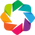

In [49]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import hvplot.pandas
import pandas as pd
import numpy as np
import requests
import json
import os
import holoviews as hv
hv.extension('bokeh')


# Import API key
from api_keys import geoapify_key

In [24]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("output_data/cities.csv")

# Display sample data
city_data_df.head()

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,delta,5.5000,6.0000,27.56,82,0,2.23,NG,1707778494
1,1,isafjordur,66.0755,-23.1240,-0.50,81,100,10.05,IS,1707778552
2,2,bilibino,68.0546,166.4372,-36.87,98,93,1.00,RU,1707778552
3,3,petropavlovsk-kamchatsky,53.0452,158.6483,-18.08,81,0,4.00,RU,1707778553
4,4,strathalbyn,-35.2667,138.9000,29.25,45,7,4.82,AU,1707778554


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

In [ ]:
# Configure the map plot
plot_city = city_data_df.hvplot.points(x='Lng', y='Lat', size = "Humidity", geo = True, tiles = "OSM", \
                                  frame_width = 800, frame_height = 600, color = "City")


# Display the map
hvplot.show(plot_city)

#hv.extension('bokeh')
#from bokeh.plotting import show
#show(hv.render(plot_city))


### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [48]:
ideal_df = city_data_df.loc[(city_data_df['Max Temp']>=21.03)\
                            &(city_data_df['Max Temp']<=26.27)\
                             &(city_data_df['Cloudiness']==0)\
                            &(city_data_df['Humidity']>=50),:]
print(len(ideal_df))

# Drop any rows with null values
ideal_df.dropna()

# Display sample data
ideal_df

10


,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
9,9,wailua homesteads,22.0669,-159.3780,25.63,57,0,4.12,US,1707778033
48,48,east london,-33.0153,27.9116,22.47,84,0,8.35,ZA,1707778584
94,94,cabo san lucas,22.8909,-109.9124,24.78,59,0,4.39,MX,1707778429
134,134,port elizabeth,-33.9180,25.5701,22.40,88,0,1.34,ZA,1707778643
137,137,holualoa,19.6228,-155.9522,24.91,67,0,4.12,US,1707778645
155,155,piton saint-leu,-21.2196,55.3151,25.04,83,0,1.03,RE,1707778659
180,180,panaba,21.2833,-88.2667,25.24,84,0,5.41,MX,1707778680
240,240,port lincoln,-34.7333,135.8667,21.48,59,0,5.09,AU,1707778726
280,280,carnarvon,-24.8667,113.6333,24.13,83,0,8.45,AU,1707778752
429,429,rosarito,32.3333,-117.0333,21.07,56,0,5.45,MX,1707778808


### Step 3: Create a new DataFrame called `hotel_df`.

In [51]:
# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
hotel_df = city_data_df.copy()

hotel_df = hotel_df[["City","Country","Lat","Lng","Humidity"]]

# Add an empty column, "Hotel Name," to the DataFrame so you can store the hotel found using the Geoapify API
hotel_df["Hotel Name"] = ""

# Display sample data
hotel_df

,City,Country,Lat,Lng,Humidity,Hotel Name
0,delta,NG,5.5000,6.0000,82,
1,isafjordur,IS,66.0755,-23.1240,81,
2,bilibino,RU,68.0546,166.4372,98,
3,petropavlovsk-kamchatsky,RU,53.0452,158.6483,81,
4,strathalbyn,AU,-35.2667,138.9000,45,
...,...,...,...,...,...,...
553,dalnegorsk,RU,44.5604,135.5701,67,
554,kosong,KR,38.3788,128.4676,77,
555,carmo do rio claro,BR,-20.9719,-46.1189,73,
556,pangody,RU,65.8500,74.4859,99,


### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [52]:
# Set parameters to search for a hotel
radius = # YOUR CODE HERE
params = {
    # YOUR CODE HERE
}

# Print a message to follow up the hotel search
print("Starting hotel search")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    # get latitude, longitude from the DataFrame
    # YOUR CODE HERE
    
    # Add filter and bias parameters with the current city's latitude and longitude to the params dictionary
    params["filter"] = # YOUR CODE HERE
    params["bias"] = # YOUR CODE HERE
    
    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"


    # Make and API request using the params dictionaty
    name_address = # YOUR CODE HERE
    
    # Convert the API response to JSON format
    name_address = # YOUR CODE HERE
    
    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"
        
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Display sample data

Starting hotel search
delta - nearest hotel: No hotel found
isafjordur - nearest hotel: No hotel found
bilibino - nearest hotel: No hotel found
petropavlovsk-kamchatsky - nearest hotel: No hotel found
strathalbyn - nearest hotel: No hotel found
waitangi - nearest hotel: No hotel found
vallenar - nearest hotel: No hotel found
verkhniy baskunchak - nearest hotel: No hotel found
trenggalek - nearest hotel: No hotel found
wailua homesteads - nearest hotel: No hotel found
brooks - nearest hotel: No hotel found
mata-utu - nearest hotel: No hotel found
anadyr - nearest hotel: No hotel found
avarua - nearest hotel: No hotel found
blackmans bay - nearest hotel: No hotel found
west island - nearest hotel: No hotel found
kodiak - nearest hotel: No hotel found
suva - nearest hotel: No hotel found
vicuna mackenna - nearest hotel: No hotel found
bac lieu - nearest hotel: No hotel found
prabumulih - nearest hotel: No hotel found
punta arenas - nearest hotel: No hotel found
campoverde - nearest hotel:

,City,Country,Lat,Lng,Humidity,Hotel Name
0,delta,NG,5.5000,6.0000,82,No hotel found
1,isafjordur,IS,66.0755,-23.1240,81,No hotel found
2,bilibino,RU,68.0546,166.4372,98,No hotel found
3,petropavlovsk-kamchatsky,RU,53.0452,158.6483,81,No hotel found
4,strathalbyn,AU,-35.2667,138.9000,45,No hotel found
...,...,...,...,...,...,...
553,dalnegorsk,RU,44.5604,135.5701,67,No hotel found
554,kosong,KR,38.3788,128.4676,77,No hotel found
555,carmo do rio claro,BR,-20.9719,-46.1189,73,No hotel found
556,pangody,RU,65.8500,74.4859,99,No hotel found


### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

In [7]:
%%capture --no-display

# Configure the map plot
# YOUR CODE HERE

# Display the map
# YOUR CODE HERE

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lng,Lat]   (City,Humidity,Hotel Name,Country)